#### This program estimates alpha according to author(first/total authors) frequency
We bin the articles for each quarter into two bins: 
    1. Written by authors with fewer than three publications in that month 
    2. Written by authors with two or more publications in that month 

In [5]:
from base import * 
import pandas as pd 
import os 
import pickle 
from pathlib import Path 
from src.estimation import estimate_text_distribution
from src.MLE import MLE
import warnings
import numpy as np 
import matplotlib.pyplot as plt 
from copy import deepcopy 
warnings.filterwarnings("ignore")

In [3]:
subject = "education"
base_loc = f"inference_data/{subject}"
years = [2024, 2023, 2022, 2021]

In [46]:
def categorize_by_authors(collection):
    """
    maps authors to their corresponding articles  
    Args:
        collection: (base.ArticleCollection)
    Returns:
        (dict) (str) author name -> (List[int]) List of article ids
    """
    
    author_dict = {}
    count = 0 
    for ar_id in collection.all_articles:
        count += 1
        ar = collection.all_articles[ar_id]
        if ar.authors is not None and len(ar.authors) > 0:
            # all author data 
            #for author in ar.authors:
            #    if author not in author_dict:
            #        author_dict[author] = []
            #    author_dict[author].append(ar_id)
            
            ## first author data 
            author = ar.authors[0]
            if author not in author_dict:
                author_dict[author] = []
            author_dict[author].append(ar_id)

    return author_dict

def bin_by_freq(data_dict, cutoff=2):
    """
    bins the data into two groups according to the cutoff
    Args:
        cutoff: (int) 
        data_dict: (dict) (object) -> List[object]
    """
    
    cutoff_left = []
    cutoff_right = []
    for key in data_dict:
        if len(data_dict[key]) <= cutoff:
            cutoff_left += data_dict[key]
        else:
            cutoff_right += data_dict[key]
            
    return set(cutoff_left), set(cutoff_right)

def add_to_sub_collection(sub_collection, main_collection, ids=None):
    """
    add selected articles from the main collection to sub-collection
    Args:
        sub_collection: (ArticleCollection)
        main_collection: (ArticleCollection) 
        ids: (List[object]) list of ids of articles of interest 
    """
    if ids is None:
        ids = list(main_collection.all_articles.keys())
    for id_ in ids:
        sub_collection.add_article(main_collection.get_article(id_), id_)

def combine_collections(coll_list):
    """
    combine the a group of collections into a single collection
    """
    if coll_list is None:
        raise ValueError("the parameter is None")
    if len(coll_list) == 0:
        raise ValueError("empty collection list")
        
    sample = coll_list[0]
    collection = ArticleCollection(subject=sample.subject)
    for coll in coll_list:
        add_to_sub_collection(collection, coll)
        
    return collection 
    

In [47]:
thresh = 2 # equals the value in Liang et al.
dest = Path("inference_data/parquet_files/first_author_quarterly/{}".format(subject))
dest.mkdir(parents=True, exist_ok=True)
time_window = 3
for year in [2024, 2023, 2022, 2021]:
    dest_year = dest / str(year)
    dest_year.mkdir(parents=True, exist_ok=True)
    quarterly_data = []
    months = np.arange(1, 13)
    q_count = 0
    for m in months:
        full_path = f"{base_loc}/{year}/{subject}_{year}_{m}.pkl"
        with open(full_path, "rb") as f:
            data = pickle.load(f)
            print("Year: {}, Month:{}, Size:{}".format(year, m, data.get_size()))
            quarterly_data.append(data) 
            if len(quarterly_data) == time_window:
                combined = combine_collections(quarterly_data)
                print("combined_size:", combined.get_size())
                quarterly_data = []
                by_author = categorize_by_authors(combined)
                q_count += 1
                name = f"{subject}_{year}_{q_count}"
                if len(by_author) > 0:
                    group1, group2 = bin_by_freq(by_author)
                    print("Year: {}, Months: {}-{}, total: {}, less than {}: {}, more than {}:{}".format(
                            year, m-2, m, combined.get_size(), thresh, len(group1), thresh, len(group2)))
                    collection1 = ArticleCollection(subject, year)
                    collection2 = ArticleCollection(subject, year)
                    add_to_sub_collection(collection1, combined, group1)
                    add_to_sub_collection(collection2, combined, group2)
                    collection1.export_parquet(dest_year, f"{name}_less")
                    collection2.export_parquet(dest_year, f"{name}_more")

Year: 2024, Month:1, Size:2836
Year: 2024, Month:2, Size:2353
Year: 2024, Month:3, Size:2893
combined_size: 8082
Year: 2024, Months: 1-3, total: 8082, less than 2: 7663, more than 2:377
Exporting parquet


100%|███████████████████████████████████████| 7663/7663 [03:23<00:00, 37.70it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2024/education_2024_1_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 377/377 [00:06<00:00, 54.11it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2024/education_2024_1_more.parquet
Year: 2024, Month:4, Size:1166
Year: 2024, Month:5, Size:6
Year: 2024, Month:6, Size:25
combined_size: 1197
Year: 2024, Months: 4-6, total: 1197, less than 2: 1177, more than 2:20
Exporting parquet


100%|███████████████████████████████████████| 1177/1177 [00:33<00:00, 35.41it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2024/education_2024_2_less.parquet
Exporting parquet


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.72it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2024/education_2024_2_more.parquet
Year: 2024, Month:7, Size:0
Year: 2024, Month:8, Size:4
Year: 2024, Month:9, Size:1
combined_size: 5
Year: 2024, Months: 7-9, total: 5, less than 2: 5, more than 2:0
Exporting parquet


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 26.15it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2024/education_2024_3_less.parquet
Exporting parquet


0it [00:00, ?it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2024/education_2024_3_more.parquet
Year: 2024, Month:10, Size:0
Year: 2024, Month:11, Size:0
Year: 2024, Month:12, Size:2
combined_size: 2
Year: 2024, Months: 10-12, total: 2, less than 2: 2, more than 2:0
Exporting parquet


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 30.52it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2024/education_2024_4_less.parquet
Exporting parquet


0it [00:00, ?it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2024/education_2024_4_more.parquet
Year: 2023, Month:1, Size:2677
Year: 2023, Month:2, Size:2532
Year: 2023, Month:3, Size:3504
combined_size: 8713
Year: 2023, Months: 1-3, total: 8713, less than 2: 7974, more than 2:644
Exporting parquet


100%|███████████████████████████████████████| 7974/7974 [03:38<00:00, 36.57it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2023/education_2023_1_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 644/644 [00:14<00:00, 45.78it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2023/education_2023_1_more.parquet
Year: 2023, Month:4, Size:3573
Year: 2023, Month:5, Size:3737
Year: 2023, Month:6, Size:4869
combined_size: 12179
Year: 2023, Months: 4-6, total: 12179, less than 2: 11005, more than 2:1109
Exporting parquet


100%|█████████████████████████████████████| 11005/11005 [05:02<00:00, 36.39it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2023/education_2023_2_less.parquet
Exporting parquet


100%|███████████████████████████████████████| 1109/1109 [00:23<00:00, 47.13it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2023/education_2023_2_more.parquet
Year: 2023, Month:7, Size:3365
Year: 2023, Month:8, Size:2926
Year: 2023, Month:9, Size:2752
combined_size: 9043
Year: 2023, Months: 7-9, total: 9043, less than 2: 8550, more than 2:455
Exporting parquet


100%|███████████████████████████████████████| 8550/8550 [04:14<00:00, 33.62it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2023/education_2023_3_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 455/455 [00:11<00:00, 38.25it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2023/education_2023_3_more.parquet
Year: 2023, Month:10, Size:2878
Year: 2023, Month:11, Size:3090
Year: 2023, Month:12, Size:4704
combined_size: 10672
Year: 2023, Months: 10-12, total: 10672, less than 2: 10209, more than 2:405
Exporting parquet


100%|█████████████████████████████████████| 10209/10209 [04:39<00:00, 36.51it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2023/education_2023_4_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 405/405 [00:08<00:00, 47.07it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2023/education_2023_4_more.parquet
Year: 2022, Month:1, Size:2098
Year: 2022, Month:2, Size:2198
Year: 2022, Month:3, Size:2403
combined_size: 6699
Year: 2022, Months: 1-3, total: 6699, less than 2: 6165, more than 2:509
Exporting parquet


100%|███████████████████████████████████████| 6165/6165 [02:55<00:00, 35.10it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2022/education_2022_1_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 509/509 [00:12<00:00, 40.69it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2022/education_2022_1_more.parquet
Year: 2022, Month:4, Size:2489
Year: 2022, Month:5, Size:2292
Year: 2022, Month:6, Size:3870
combined_size: 8651
Year: 2022, Months: 4-6, total: 8651, less than 2: 7994, more than 2:630
Exporting parquet


100%|███████████████████████████████████████| 7994/7994 [03:36<00:00, 36.94it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2022/education_2022_2_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 630/630 [00:14<00:00, 44.45it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2022/education_2022_2_more.parquet
Year: 2022, Month:7, Size:2181
Year: 2022, Month:8, Size:2130
Year: 2022, Month:9, Size:2348
combined_size: 6659
Year: 2022, Months: 7-9, total: 6659, less than 2: 6183, more than 2:455
Exporting parquet


100%|███████████████████████████████████████| 6183/6183 [02:53<00:00, 35.62it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2022/education_2022_3_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 455/455 [00:11<00:00, 40.21it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2022/education_2022_3_more.parquet
Year: 2022, Month:10, Size:2481
Year: 2022, Month:11, Size:3044
Year: 2022, Month:12, Size:4669
combined_size: 10194
Year: 2022, Months: 10-12, total: 10194, less than 2: 9388, more than 2:762
Exporting parquet


100%|███████████████████████████████████████| 9388/9388 [04:08<00:00, 37.72it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2022/education_2022_4_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 762/762 [00:19<00:00, 39.48it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2022/education_2022_4_more.parquet
Year: 2021, Month:1, Size:1778
Year: 2021, Month:2, Size:1641
Year: 2021, Month:3, Size:2152
combined_size: 5571
Year: 2021, Months: 1-3, total: 5571, less than 2: 4940, more than 2:588
Exporting parquet


100%|███████████████████████████████████████| 4940/4940 [02:16<00:00, 36.28it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2021/education_2021_1_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 588/588 [00:17<00:00, 34.34it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2021/education_2021_1_more.parquet
Year: 2021, Month:4, Size:2256
Year: 2021, Month:5, Size:2421
Year: 2021, Month:6, Size:3045
combined_size: 7722
Year: 2021, Months: 4-6, total: 7722, less than 2: 6557, more than 2:1114
Exporting parquet


100%|███████████████████████████████████████| 6557/6557 [03:00<00:00, 36.30it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2021/education_2021_2_less.parquet
Exporting parquet


100%|███████████████████████████████████████| 1114/1114 [00:32<00:00, 34.58it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2021/education_2021_2_more.parquet
Year: 2021, Month:7, Size:2162
Year: 2021, Month:8, Size:2074
Year: 2021, Month:9, Size:2182
combined_size: 6418
Year: 2021, Months: 7-9, total: 6418, less than 2: 5844, more than 2:542
Exporting parquet


100%|███████████████████████████████████████| 5844/5844 [52:16<00:00,  1.86it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2021/education_2021_3_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 542/542 [00:16<00:00, 33.57it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2021/education_2021_3_more.parquet
Year: 2021, Month:10, Size:2019
Year: 2021, Month:11, Size:2382
Year: 2021, Month:12, Size:3959
combined_size: 8360
Year: 2021, Months: 10-12, total: 8360, less than 2: 7516, more than 2:782
Exporting parquet


100%|███████████████████████████████████████| 7516/7516 [03:47<00:00, 33.10it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2021/education_2021_4_less.parquet
Exporting parquet


100%|█████████████████████████████████████████| 782/782 [00:21<00:00, 36.57it/s]


File Exported as: inference_data/parquet_files/first_author_quarterly/education/2021/education_2021_4_more.parquet


In [48]:
parquet_base_loc = "inference_data/parquet_files/first_author_quarterly/{}".format(subject)
name = "ojs_ed"
all_results_less = {}
all_results_more = {}
model= MLE(f"distribution/{name}.parquet")
for year in [2024, 2023, 2022, 2021]:
    if year not in all_results_less:
        all_results_less[year] = {}
    if year not in all_results_more:
        all_results_more[year] = {}
    parquet_year_path = "{}/{}".format(parquet_base_loc, year) 
    for f in sorted(os.listdir(parquet_year_path)):
        if ".parquet" in f and "whole" not in f:
            print("File: {}".format(f))
            quarter = int(f.strip(".parquet").split("_")[-2])
            full_path = "{}/{}".format(parquet_year_path, f)
            estimated,ci = model.inference(full_path,
                                     ground_truth=None, save=False)
            if estimated is not None and ci is not None :
                print(f"{estimated:10.3f},{ci:10.3f}")
                if "less" in f:
                    all_results_less[year][quarter] = (estimated, ci)
                elif "more" in f:
                    all_results_more[year][quarter] = (estimated, ci)

File: education_2024_1_less.parquet
     0.268,     0.004
File: education_2024_1_more.parquet
     0.548,     0.032
File: education_2024_2_less.parquet
     0.291,     0.011
File: education_2024_2_more.parquet
     0.410,     0.074
File: education_2024_3_less.parquet
     0.411,     0.156
File: education_2024_3_more.parquet
ERROR
File: education_2024_4_less.parquet
     0.414,     0.318
File: education_2024_4_more.parquet
ERROR
File: education_2023_1_less.parquet
     0.075,     0.003
File: education_2023_1_more.parquet
     0.085,     0.012
File: education_2023_2_less.parquet
     0.117,     0.003
File: education_2023_2_more.parquet
     0.208,     0.013
File: education_2023_3_less.parquet
     0.151,     0.003
File: education_2023_3_more.parquet
     0.210,     0.017
File: education_2023_4_less.parquet
     0.206,     0.003
File: education_2023_4_more.parquet
     0.244,     0.022
File: education_2022_1_less.parquet
     0.056,     0.003
File: education_2022_1_more.parquet
     0.069

In [49]:
output_folder = Path("output")
output_folder.mkdir(parents=True, exist_ok=True) 
with open(output_folder / "first_author_trend_results_less_quarter.pkl", "wb") as f:
    pickle.dump(all_results_less, f) 
with open(output_folder / "first_author_trend_results_more_quarter.pkl", "wb") as f:
    pickle.dump(all_results_more, f)

m: [0.044 0.078 0.053 0.055 0.069 0.078 0.044 0.076 0.085 0.208 0.21  0.244
 0.548]


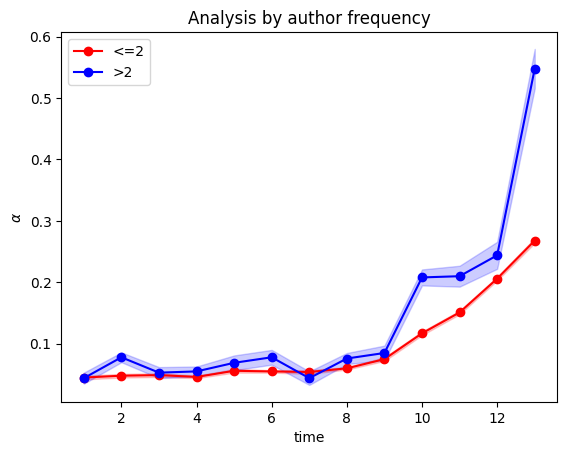

In [51]:
def convert_to_array(all_results):
    """
    extracts the alpha and confidence interval values from a dictionary 
    and converts them into array
    """
    alpha_li = []
    ci_li = []
    year_month = []
    for key1 in sorted(all_results.keys()):
        for key2 in sorted(all_results[key1]):
            if key1 != 2024:
                alpha_li.append(all_results[key1][key2][0])
                ci_li.append(all_results[key1][key2][1])
            else:
                if key2 < 2:
                    alpha_li.append(all_results[key1][key2][0])
                    ci_li.append(all_results[key1][key2][1])
            year_month.append("{}-{}".format(key1, key2))
    return np.asarray(alpha_li), np.asarray(ci_li), year_month


#output_folder = Path("output")
#output_folder.mkdir(parents=True, exist_ok=True) 
#with open(output_folder / "author_trend_results_less.pkl", "rb") as f:
#    all_results_less = pickle.load(f)
#with open(output_folder / "author_trend_results_more.pkl", "rb") as f:
#    all_results_more = pickle.load(f)
    
alpha_s, ci_s, x_lab = convert_to_array(all_results_less)
alpha_m, ci_m, x_lab = convert_to_array(all_results_more)
time = np.arange(1, len(alpha_s) +1)
#xticks = np.arange(0, len(ci_s), 3)
print("m:", alpha_m)
#tick_labs = [x_lab[i] for i in xticks]
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1) 
axes.set_xlabel("time")
axes.set_ylabel(r"$\alpha$") 
axes.set_title("Analysis by author frequency")
axes.plot(time, alpha_s, "-o", label="<={}".format(2), color="red")
axes.plot(time, alpha_m, "-o", label=">{}".format(2), color="blue")
axes.fill_between(time, (alpha_s-ci_s), (alpha_s+ci_s), 
                color='red', alpha=.2)
axes.fill_between(time, (alpha_m-ci_m), (alpha_m+ci_m), 
                color='blue', alpha=.2)
axes.legend()
#axes.set_xticks(xticks, tick_labs, rotation=90)